<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
C:\Users\G\AppData\Local\Temp\ipykernel_26472\3726421622.py:3: SyntaxWarning: invalid escape sequence '\g'
  df = pd.read_csv("data\gfp_ground_truth.csv")


                                            sequence     score
0  SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  3.718386
1  SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  3.622869
2  SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  3.722241
3  SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  3.697823
4  SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...  3.804003
              score
count  56086.000000
mean       2.731658
std        1.052256
min        1.283419
25%        1.466385
50%        3.377876
75%        3.635888
max        4.123109
sequence    0
score       0
dtype: int64


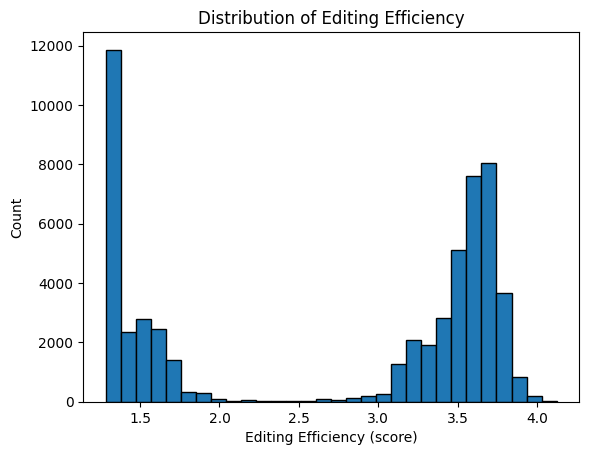

In [3]:
import pandas as pd

df = pd.read_csv("data\gfp_ground_truth.csv")


print(df.head())


print(df.describe())


print(df.isnull().sum())
import matplotlib.pyplot as plt

plt.hist(df["score"], bins=30, edgecolor="black")
plt.xlabel("Editing Efficiency (score)")
plt.ylabel("Count")
plt.title("Distribution of Editing Efficiency")
plt.show()

In [4]:
import numpy as np

AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWY"
aa_to_idx = {aa: idx for idx, aa in enumerate(AMINO_ACIDS)}

def one_hot_encode(seq, max_len):
    encoding = np.zeros((max_len, len(AMINO_ACIDS)), dtype=np.float32)
    for i, aa in enumerate(seq):
        if i >= max_len:
            break
        if aa in aa_to_idx:
            encoding[i, aa_to_idx[aa]] = 1.0
    return encoding

def embed_sequences_onehot(sequences):
    max_len = max(len(s) for s in sequences)
    embeddings = []
    for seq in sequences:
        oh = one_hot_encode(seq, max_len)
        mean_pooled = oh.mean(axis=0)
        embeddings.append(mean_pooled)
    return np.vstack(embeddings)


import pandas as pd

df = pd.read_csv("data\gfp_ground_truth.csv")
sequences = df["sequence"].tolist()
y = df["score"].values

X = embed_sequences_onehot(sequences)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


<>:27: SyntaxWarning: invalid escape sequence '\g'
<>:27: SyntaxWarning: invalid escape sequence '\g'
C:\Users\G\AppData\Local\Temp\ipykernel_26472\824234751.py:27: SyntaxWarning: invalid escape sequence '\g'
  df = pd.read_csv("data\gfp_ground_truth.csv")


XGBoost:
  R² = 0.459, MSE = 0.0118
MLP:
  R² = 0.118, MSE = 0.0192


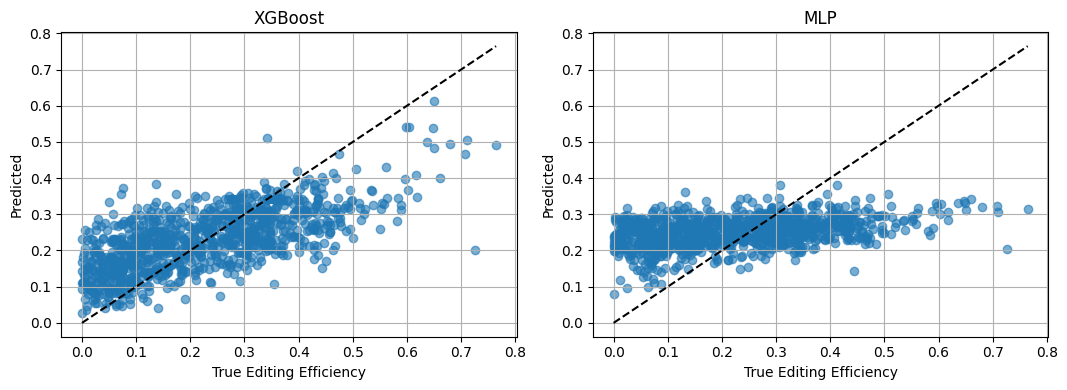

In [10]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name}:\n  R² = {r2:.3f}, MSE = {mse:.4f}")
    return y_pred

models = {
    # "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42),
     "MLP": MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', max_iter=1000, random_state=42)
}

results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, name)

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))
for i, (name, y_pred) in enumerate(results.items()):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel("True Editing Efficiency")
    plt.ylabel("Predicted")
    plt.title(name)
    plt.grid(True)

plt.tight_layout()
plt.show()


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Simple Feedforward Regressor
class RegressorNet(nn.Module):
    def __init__(self, input_dim):
        super(RegressorNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Output: single value
        )
        
    def forward(self, x):
        return self.net(x)

# Example usage
def train_model(X_train, y_train, X_val, y_val, num_epochs=50, batch_size=16, lr=1e-3, model=None):
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # Data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    if model is None:
        model = RegressorNet(input_dim=X_train.shape[1])
        model = model.to("cuda" if torch.cuda.is_available() else "cpu")
    else:
        model = model.to("cuda" if torch.cuda.is_available() else "cpu")
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(model.net[0].weight.device), batch_y.to(model.net[0].weight.device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_X.size(0)
        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(model.net[0].weight.device), batch_y.to(model.net[0].weight.device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_X.size(0)
        val_loss /= len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return model


In [30]:
from sklearn.model_selection import train_test_split
import numpy as np
# X = your embeddings (numpy array)
# y = your target values
import pandas as pd
X = np.load("embeddings/adar2_esm2_embeddings.npy")
df = pd.read_csv("data/adar2_mutated_sequences.csv")
y = df["mean_rate"].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = train_model(X_train, y_train, X_val, y_val, num_epochs=50, model=model)


Epoch 1/50 | Train Loss: 0.0185 | Val Loss: 0.0187
Epoch 2/50 | Train Loss: 0.0183 | Val Loss: 0.0185
Epoch 3/50 | Train Loss: 0.0182 | Val Loss: 0.0194
Epoch 4/50 | Train Loss: 0.0183 | Val Loss: 0.0186
Epoch 5/50 | Train Loss: 0.0184 | Val Loss: 0.0185
Epoch 6/50 | Train Loss: 0.0183 | Val Loss: 0.0189
Epoch 7/50 | Train Loss: 0.0185 | Val Loss: 0.0188
Epoch 8/50 | Train Loss: 0.0184 | Val Loss: 0.0186
Epoch 9/50 | Train Loss: 0.0182 | Val Loss: 0.0187
Epoch 10/50 | Train Loss: 0.0182 | Val Loss: 0.0189
Epoch 11/50 | Train Loss: 0.0182 | Val Loss: 0.0184
Epoch 12/50 | Train Loss: 0.0182 | Val Loss: 0.0190
Epoch 13/50 | Train Loss: 0.0185 | Val Loss: 0.0186
Epoch 14/50 | Train Loss: 0.0182 | Val Loss: 0.0222
Epoch 15/50 | Train Loss: 0.0183 | Val Loss: 0.0186
Epoch 16/50 | Train Loss: 0.0180 | Val Loss: 0.0195
Epoch 17/50 | Train Loss: 0.0182 | Val Loss: 0.0185
Epoch 18/50 | Train Loss: 0.0180 | Val Loss: 0.0193
Epoch 19/50 | Train Loss: 0.0180 | Val Loss: 0.0191
Epoch 20/50 | Train L

In [18]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

torch.Size([4160, 320]) torch.Size([1041, 320])

PyTorch Regressor:
  Train R² = 0.143, MSE = 0.0181
  Test  R² = 0.136, MSE = 0.0188


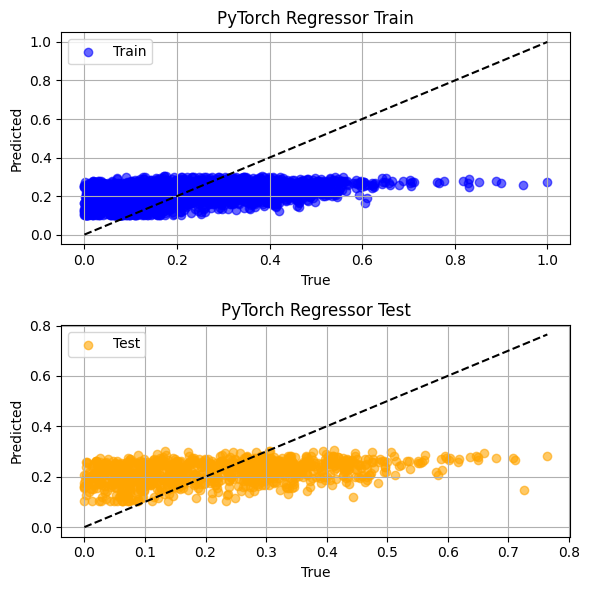

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import joblib
import os

def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        model.to("cpu")  # Ensure model is on CPU for evaluation
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to("cpu")
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to("cpu")
        print(X_train_tensor.shape, X_test_tensor.shape)
        y_pred_train = model(X_train_tensor)
        y_pred_test = model(X_test_tensor)
        y_pred_train= y_pred_train.detach().numpy()
        y_pred_test = y_pred_test.detach().numpy()
        r2_train = r2_score(y_train, y_pred_train)
        mse_train = mean_squared_error(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        mse_test = mean_squared_error(y_test, y_pred_test)
        print(f"\n{name}:")
        print(f"  Train R² = {r2_train:.3f}, MSE = {mse_train:.4f}")
        print(f"  Test  R² = {r2_test:.3f}, MSE = {mse_test:.4f}")
        results[name] = {
            "y_train": y_pred_train,
            "y_test": y_pred_test
        }
    return results

models = {
    "PyTorch Regressor": model
}
results = evaluate_models(models, X_train, y_train, X_val, y_val)

def plot_results(y_train, y_test, results):
    plt.figure(figsize=(6, 6))
    for i, (name, preds) in enumerate(results.items()):
        # Train
        plt.subplot(2, len(results), i + 1)
        plt.scatter(y_train, preds["y_train"], alpha=0.6, color="blue", label="Train")
        plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "k--")
        plt.xlabel("True")
        plt.ylabel("Predicted")
        plt.title(f"{name} Train")
        plt.grid(True)
        plt.legend()
        # Test
        plt.subplot(2, len(results), i + 1 + len(results))
        plt.scatter(y_test, preds["y_test"], alpha=0.6, color="orange", label="Test")
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--")
        plt.xlabel("True")
        plt.ylabel("Predicted")
        plt.title(f"{name} Test")
        plt.grid(True)
        plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_results(y_train, y_val, results)